# Region growing implementation

This notebooks aims inspect a region growing algorithm that works well for CMB

In [31]:
import utils.utils_loading as utils_load
import numpy as np
import nibabel as nib
import nilearn as nil
import pandas as pd
import SimpleITK as sitk
from tqdm import tqdm
import os
from utils.utils_plotting import plot_mask_on_image
from scipy.ndimage import binary_dilation, binary_erosion, generate_binary_structure, \
    label, center_of_mass, binary_fill_holes



In [32]:
# rawdata
# rawdata_dir = "/datadrive_m2/jorge/data/VALDO"
rawdata_dir = "/home/cerebriu/data/datasets/VALDO"

# newdata
# data_dir = "/datadrive_m2/jorge/TEST/VALDO/Data"
data_dir = "/home/cerebriu/data/datasets/VALDO_processed/Data"

## Custom implementation

In [33]:
def is_within_bounds(coords, shape):
    """Check if the coordinates are within the bounds of the array."""
    return all(0 <= coords[dim] < shape[dim] for dim, val in enumerate(coords))

def get_neighbors_6n(coords):
    """Get the 6 face-adjacent neighbors in 3D."""
    x, y, z = coords
    return [(x-1, y, z), (x+1, y, z), 
            (x, y-1, z), (x, y+1, z), 
            (x, y, z-1), (x, y, z+1)]

def get_neighbors_26n(coords):
    """Get all 26 possible neighbors in 3D (including diagonals)."""
    neighbors = []
    for x in [-1, 0, 1]:
        for y in [-1, 0, 1]:
            neighbors.extend(
                (coords[0] + x, coords[1] + y, coords[2] + z)
                for z in [-1, 0, 1]
                if (x, y, z) != (0, 0, 0)
            )
    return neighbors

# def region_growing_3d_local(volume, seed_points, tolerance, connectivity=26):
#     """Grow a region in a 3D volume based on local intensity comparison."""
#     region = np.zeros_like(volume, dtype=bool)  # The resulting binary mask
#     queue = []  # Initialize the queue for seed points

#     # Add all seed points to the region and the queue
#     for seed_point in seed_points:
#         seed_intensity = volume[seed_point]
#         if is_within_bounds(seed_point, volume.shape) and not region[seed_point]:
#             region[seed_point] = True
#             queue.append(seed_point)

#     # Select neighbor function based on the chosen connectivity
#     get_neighbors = get_neighbors_26n if connectivity == 26 else get_neighbors_6n

#     while queue:
#         point = queue.pop(0)  # Get a point from the queue
#         point_intensity = volume[point]
#         for neighbor in get_neighbors(point):
#             if is_within_bounds(neighbor, volume.shape) and not region[neighbor]:
#                 # Compare the intensity of the neighbor to the current point's intensity
#                 if abs(volume[neighbor] - point_intensity) <= tolerance:
#                     region[neighbor] = True  # Include the neighbor in the region
#                     queue.append(neighbor)  # Add the neighbor to the queue for further exploration

#     return region

def region_growing_3d_seed(volume, seed_points, tolerance, connectivity=26, size_threshold=100):
    """Grow a region in a 3D volume based on intensity differences with multiple seed points,
    and return a signal to stop investigating further tolerances if the region grows too quickly."""
    region = np.zeros_like(volume, dtype=bool)  # The resulting binary mask
    queue = []  # Initialize the queue with the seed points
    stop_signal = False  # Signal to indicate whether to stop investigating further tolerances

    # Fill the queue with seed points and initialize their intensity
    for seed_point in seed_points:
        if is_within_bounds(seed_point, volume.shape):
            region[seed_point] = True  # Mark the seed point as included in the region
            queue.append(seed_point)

    # Select neighbor function based on the chosen connectivity
    get_neighbors = get_neighbors_26n if connectivity == 26 else get_neighbors_6n

    while queue:
        point = queue.pop(0)  # Get a point from the queue
        point_intensity = volume[point]
        neighbors_added = 0  # Counter for the number of neighbors added in this iteration

        for neighbor in get_neighbors(point):
            if is_within_bounds(neighbor, volume.shape) and not region[neighbor]:
                if abs(volume[neighbor] - point_intensity) <= tolerance:
                    region[neighbor] = True  # Include the neighbor in the region
                    queue.append(neighbor)  # Add the neighbor to the queue for further exploration
                    neighbors_added += 1

                    # If adding neighbors caused the region to grow too quickly, set the stop signal
                    if np.sum(region) > size_threshold:
                        stop_signal = True
                        break  # Break out of the neighbor loop

        if stop_signal:
            break  # Break out of the main while loop if the stop signal is set

    return region, stop_signal

def region_growing_with_auto_tolerance(volume, seeds, tolerance_range=(0, 100, 1), connectivity=26, size_threshold=100):
    """ 
    Calculates results for several tolerance values and yields optimal based on 
    elbow-method
    """
    grown_regions = []
    exceeded_size_threshold = False
    len_list = []

    # Loop over the tolerance values and perform region growing
    for tolerance in tqdm(np.arange(*tolerance_range), desc="Looping over tolerances"):
        grown_region, exceeded = region_growing_3d_seed(volume, seeds, tolerance, connectivity, size_threshold)
        grown_regions.append(grown_region)
        len_list.append(np.sum(grown_region))

        # Do not continue if growing exponentially, as computationally very expensive
        if exceeded:
            exceeded_size_threshold = True
            break  # Exit if the size threshold is exceeded

    # Determine the selected tolerance based on the sudden rise (exceeded signal)
    selected_tolerance_index = len(grown_regions) - 2 if exceeded_size_threshold else len(grown_regions) - 1
    selected_tolerance = np.arange(*tolerance_range)[selected_tolerance_index]
    selected_mask = grown_regions[selected_tolerance_index]
    
    # -------------------- Cleaning of mask ----------------------------------
    
    # Define the structure for dilation and erosion based on connectivity
    struct = generate_binary_structure(volume.ndim, connectivity)
    
    # Perform one final dilation and then erosion (closing)
    closed_mask = binary_dilation(selected_mask, structure=struct, iterations=1)
    closed_mask = binary_erosion(closed_mask, structure=struct, iterations=1)
    
    # Fill holes in the mask to ensure it's solid
    closed_mask = binary_fill_holes(closed_mask, structure=struct)

    # Label the connected components
    labeled_mask, num_features = label(closed_mask, structure=struct)

    # If there are multiple features, select the largest one
    if num_features > 1:
        print(f"More than one CC found, a total of {num_features}")
        max_label = 1 + np.argmax([np.sum(labeled_mask == i) for i in range(1, num_features + 1)])
        cleaned_mask = (labeled_mask == max_label)
    else:
        cleaned_mask = closed_mask

    # Metadata
    metadata = {
        'n_pixels': np.sum(cleaned_mask),
        'tolerance_selected': selected_tolerance,
        'tolerance_pixel_counts': len_list
    }

    return cleaned_mask, metadata

### Try on cases with only 1 CMB

In [34]:
# Initialize a dictionary to store results
results_dict = {}
# subjects = os.listdir(data_dir)
sel_ids = [102, 302, 306]
subjects = [f"sub-{s}" for s in sel_ids]

for i, sub_d in enumerate(subjects):

    sub = sub_d.split("-")[1]
    subject_id = f"sub-{sub}"  # Using subject ID as the dictionary key

    print("------------------")
    print(subject_id)
    # rawdata
    mask, t2s, t2, t1 = utils_load.read_all_niftis_raw(sub, rawdata_dir)

    # newdata
    cmb, mri, metadata_raw, metadata_processed = utils_load.read_data_processed(sub, data_dir)


    # data
    cmb_data = cmb.get_fdata()
    t2s_data = mri.get_fdata()[:, :, :, 0]

    n_CMB = len(metadata_processed['T2S']['centers_of_mass'])

    if  n_CMB == 1 and np.sum(cmb_data) > 0:
        # Initialize an entry for this subject
        results_dict[subject_id] = {
            'metadata_processed': metadata_processed,
            'analysis': {},
            'processing_metadata': {}
        }

        print()
        print(metadata_processed)
        
        masked_t2s_cmb = t2s_data[cmb_data == 1]
        cmb_min = np.min(masked_t2s_cmb)
        cmb_max = np.max(masked_t2s_cmb)
        cmb_sd = np.std(masked_t2s_cmb)
        cmb_mean = np.mean(masked_t2s_cmb)
        print(
            f"min: {cmb_min} "
            f"max: {cmb_max} "
            f"mean: {cmb_mean} "
            f"std: {cmb_sd}"
        )

        # Save analysis results in the dictionary
        results_dict[subject_id]['analysis'] = {
            'min': cmb_min,
            'max': cmb_max,
            'mean': cmb_mean,
            'std': cmb_sd
        }

        cm_mask = tuple(int(x) for x in metadata_processed['T2S']['centers_of_mass'][0])
        grown_mask, process_metadata = region_growing_with_auto_tolerance(t2s_data, seeds=[cm_mask], tolerance_range=(0, 100, 0.5), connectivity=6)
        print(process_metadata)

        # Save processing metadata in the dictionary
        results_dict[subject_id]['processing_metadata'] = process_metadata
        results_dict[subject_id]['np_arrays'] = (t2s_data, cmb_data, grown_mask)
        results_dict[subject_id]['CM'] = cm_mask

    # Break after processing 5 subjects
    if i >= 10:
        break

------------------
sub-102

{'T2S': {'centers_of_mass': [[46.5, 102.5, 78.5]], 'pixel_counts': [48], 'radii': [2.254503303573653]}}
min: 58.5551643371582 max: 232.70387268066406 mean: 128.69214487075806 std: 46.35888040118629


Looping over tolerances:  30%|███       | 60/200 [00:01<00:03, 36.14it/s] 


{'n_pixels': 18, 'tolerance_selected': 29.5, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 9, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 101]}
------------------
sub-302

{'T2S': {'centers_of_mass': [[117.35526315789474, 158.56578947368422, 73.19736842105263]], 'pixel_counts': [76], 'radii': [2.627695239855779]}}
min: 16.46941566467285 max: 118.2692642211914 mean: 72.61472127312108 std: 24.95142428804752


Looping over tolerances:  18%|█▊        | 35/200 [00:00<00:03, 43.98it/s] 


{'n_pixels': 21, 'tolerance_selected': 17.0, 'tolerance_pixel_counts': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 17, 17, 18, 19, 19, 20, 20, 20, 20, 20, 21, 101]}
------------------
sub-306

{'T2S': {'centers_of_mass': [[77.14285714285714, 109.14285714285714, 111.85714285714286]], 'pixel_counts': [14], 'radii': [1.4951329367184953]}}
min: 21.691349029541016 max: 50.66432571411133 mean: 38.345232418605256 std: 8.855766552300917


Looping over tolerances:  14%|█▎        | 27/200 [00:00<00:02, 69.11it/s] 


{'n_pixels': 4, 'tolerance_selected': 13.0, 'tolerance_pixel_counts': [1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 101]}


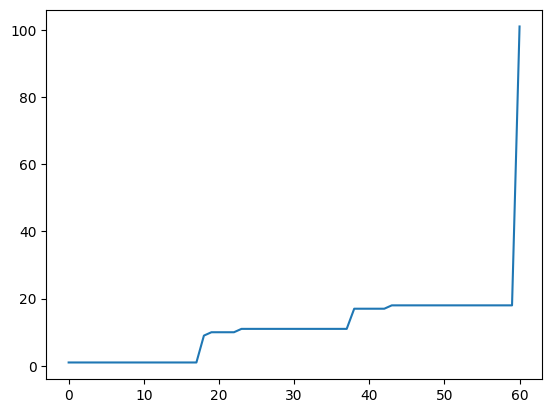

In [35]:
import matplotlib.pyplot as plt
plt.plot(results_dict['sub-102']['processing_metadata']['tolerance_pixel_counts'])

#### Inspect individual example

sub-102


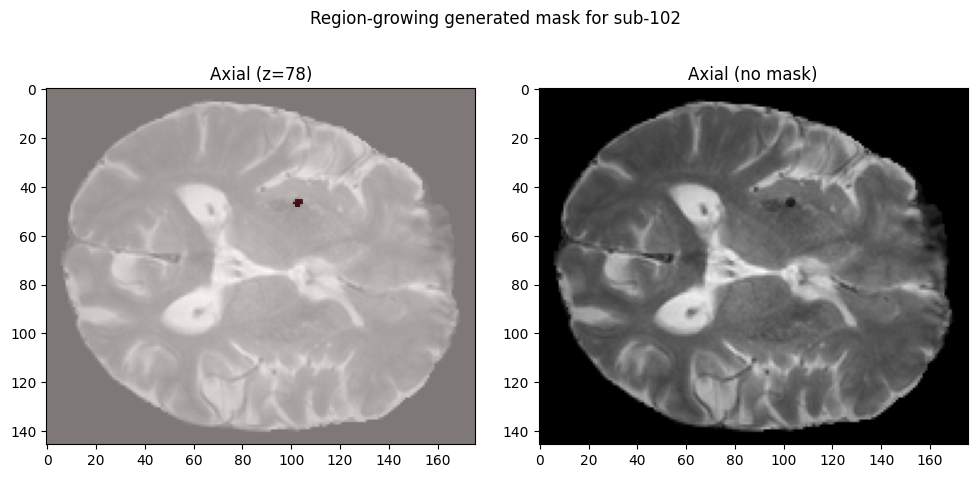

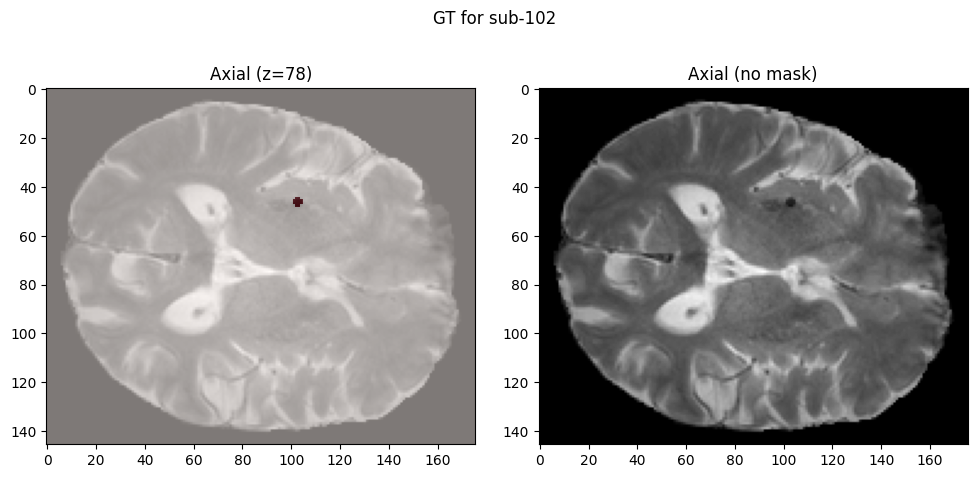

sub-302


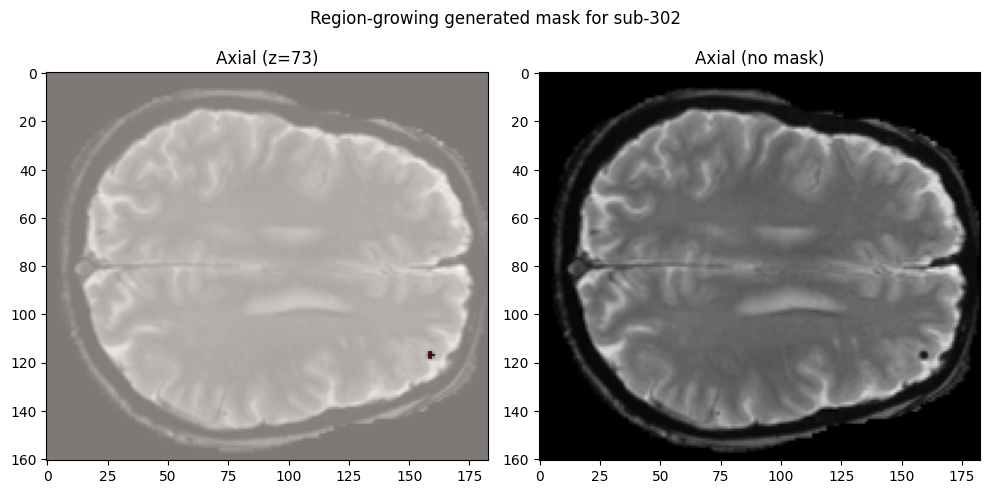

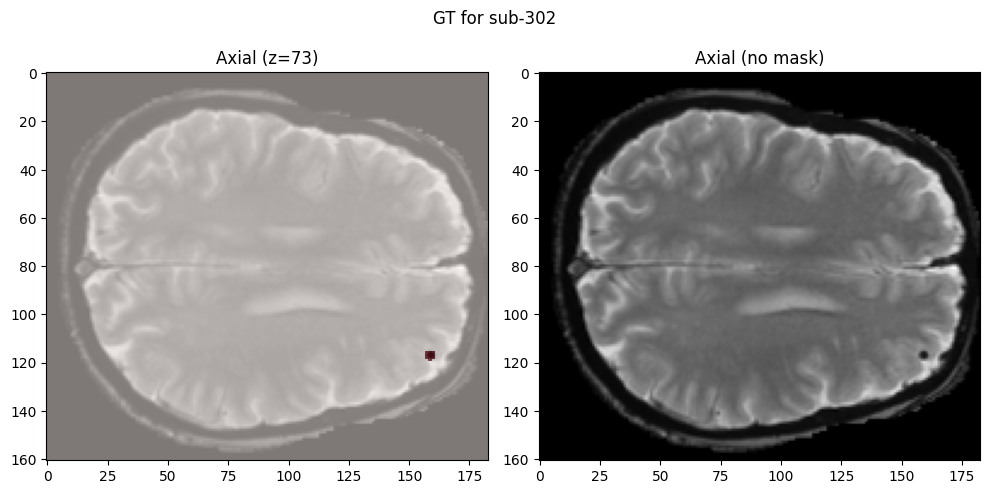

sub-306


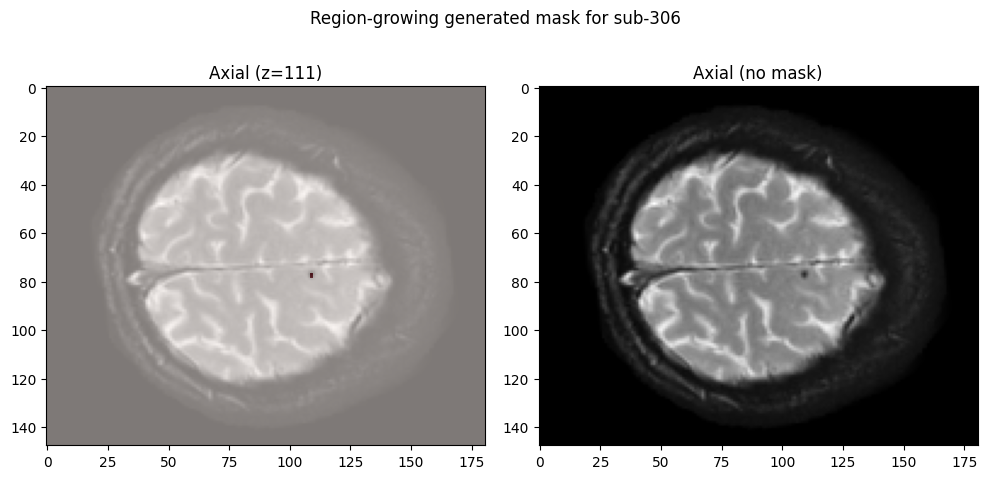

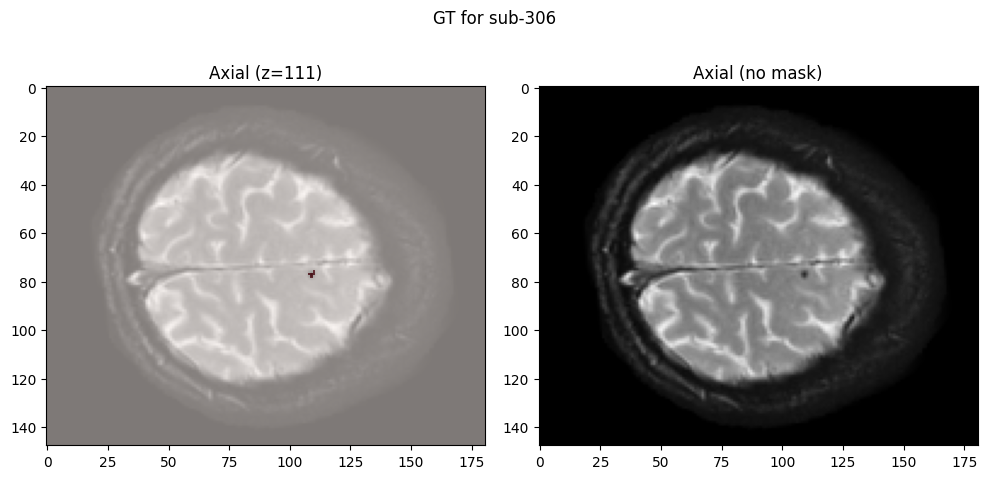

In [36]:
for sub in [102, 302, 306]:
    sub_k = f"sub-{sub}"
    print(sub_k)
    t2s_data, cmb_data, out_mask = results_dict[sub_k]['np_arrays']
    CM = results_dict[sub_k]['CM']

    plot_mask_on_image(t2s_data, out_mask, CM, title=f"Region-growing generated mask for {sub_k}", axes_to_display=['axial'])
    plot_mask_on_image(t2s_data, cmb_data, CM, title=f"GT for {sub_k}", axes_to_display=['axial'])

# SimpleITK implementation
inpired by: https://insightsoftwareconsortium.github.io/SimpleITK-Notebooks/Python_html/30_Segmentation_Region_Growing.html

In [37]:
sub = 102
sub_k = f"sub-{sub}"
t2s_data, cmb_data, out_mask = results_dict[sub_k]['np_arrays']
CM = results_dict[sub_k]['CM']
t2s_sitk = sitk.GetImageFromArray(t2s_data)

# Rescale the intensities and map them to [0,255]
t2s_sitk_255 = sitk.Cast(t2s_sitk, sitk.sitkUInt8)

## ConfidenceConnected

In [38]:
CM_sitk = t2s_sitk.TransformPhysicalPointToIndex(CM)
CM_sitk

(46, 102, 78)

In [39]:
seg_implicit_thresholds = sitk.ConfidenceConnected(t2s_sitk, 
                                                    seedList=[CM_sitk],
                                                    numberOfIterations=3,
                                                    multiplier=1,
                                                    initialNeighborhoodRadius=1,
                                                    replaceValue=1
                                                    )

In [40]:
segmentation_array = sitk.GetArrayFromImage(seg_implicit_thresholds)
t2s_sitk_np = sitk.GetArrayFromImage(t2s_sitk)

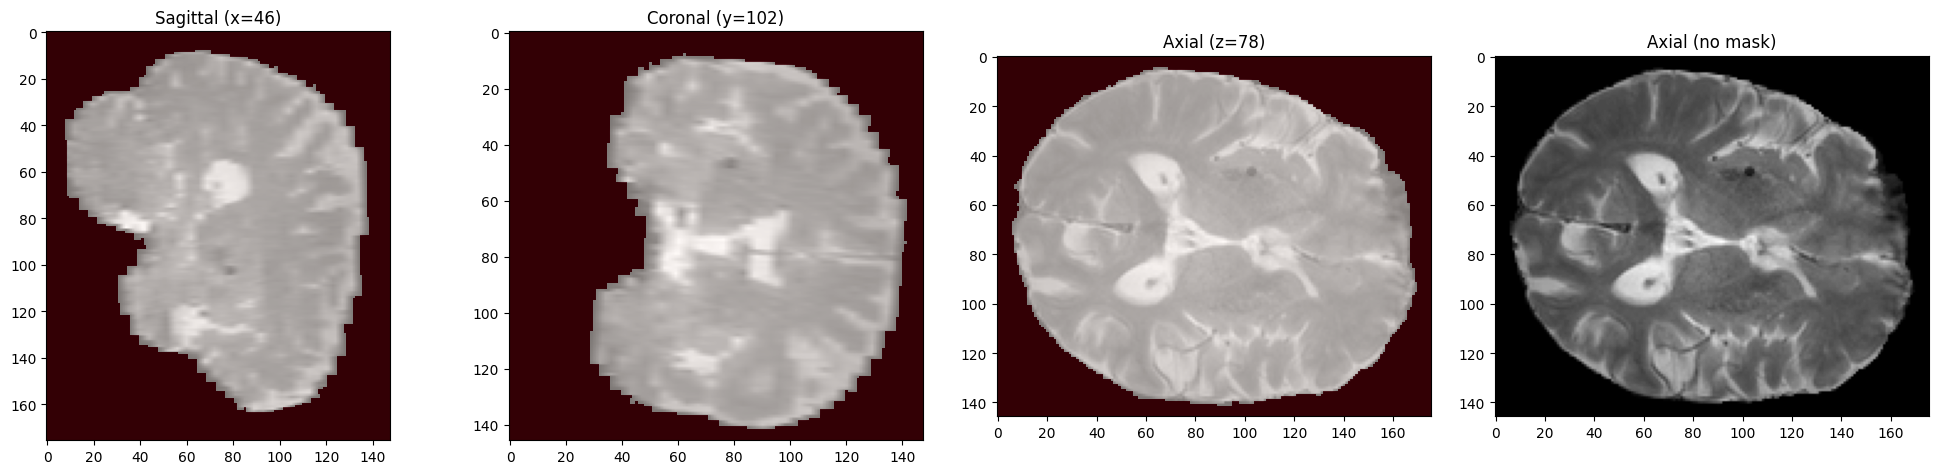

In [41]:
plot_mask_on_image(t2s_sitk_np, segmentation_array, CM)

## VectorConfidenceConnected

In [42]:
NotImplemented

NotImplemented

# Apply to CEREBRIU annotation

I annotated myself some CMB to see how region growing worked

In [43]:
# studyuid = "e2b08da90ae8beda42b900303fb33fa0d1cf3e07" # small one
studyuid = "1.2.826.1.3680043.9.5282.150415.14046.16014046222376" # big one

data_folder = "/home/cerebriu/data/RESEARCH/CMB"
mri_dir = f"{data_folder}/{studyuid}/MRIs"
cmb_nib = nib.load(f"{data_folder}/{studyuid}/Annotations/T2S_0.nii.gz")
t2s_nib = nib.load([os.path.join(mri_dir, f) for f in os.listdir(mri_dir) if "T2S" in f][0])

cmb_data = cmb_nib.get_fdata()
t2s_data = t2s_nib.get_fdata()

In [44]:
print(t2s_data.shape,
cmb_data.shape)

(270, 320, 30) (270, 320, 30)


In [45]:
np.unique(cmb_data)

array([0., 1.])

In [46]:
# cmb_data[cmb_data == 1] = 0 # in case needed
cmb_data[cmb_data == 2] = 0 # in case needed


np.sum(cmb_data == 1)
cmb_coord_where = np.where(cmb_data == 1)
cmb_coord = [(cmb_coord_where[0][i], cmb_coord_where[1][i], cmb_coord_where[2][i]) for i in range(len(cmb_coord_where[0]))]
cmb_coord

[(83, 154, 20),
 (84, 153, 20),
 (85, 153, 20),
 (86, 151, 20),
 (86, 152, 20),
 (87, 150, 20),
 (87, 151, 20)]

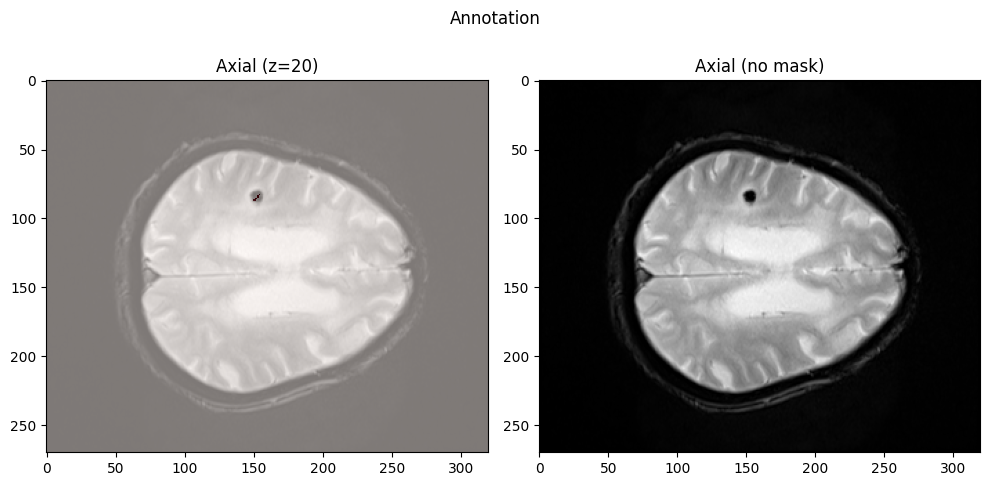

In [47]:
plot_mask_on_image(t2s_data, cmb_data, cmb_coord[0], axes_to_display=['axial'], title="Annotation")

In [48]:
masked_t2s_cmb = t2s_data[cmb_data == 1]
cmb_min = np.min(masked_t2s_cmb)
cmb_max = np.max(masked_t2s_cmb)
cmb_sd = np.std(masked_t2s_cmb)
cmb_mean = np.mean(masked_t2s_cmb)
print(
    f"min: {cmb_min} "
    f"max: {cmb_max} "
    f"mean: {cmb_mean} "
    f"std: {cmb_sd}"
)

grown_mask, process_metadata = region_growing_with_auto_tolerance(t2s_data, 
                                                                    seeds=cmb_coord, 
                                                                    tolerance_range=(0, 200, 1), 
                                                                    connectivity=6)
print(process_metadata)


# Save processing metadata in the dictionary
results_dict[subject_id]['processing_metadata'] = process_metadata
results_dict[subject_id]['np_arrays'] = (t2s_data, cmb_data, grown_mask)
results_dict[subject_id]['CM'] = cm_mask


min: 0.0 max: 57.0 mean: 18.571428571428573 std: 23.66345671438282


Looping over tolerances:  58%|█████▊    | 116/200 [00:06<00:04, 18.50it/s]


{'n_pixels': 59, 'tolerance_selected': 115, 'tolerance_pixel_counts': [16, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 27, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 32, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 35, 36, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 37, 38, 38, 38, 38, 38, 41, 41, 41, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 51, 51, 51, 53, 53, 53, 53, 53, 53, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 101]}


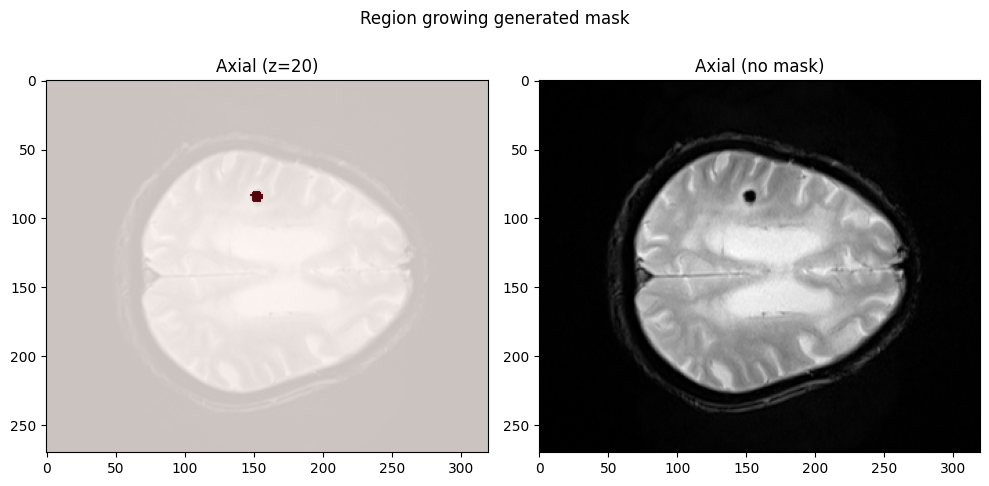

In [49]:
plot_mask_on_image(t2s_data, grown_mask, cmb_coord[0], axes_to_display=['axial'], alpha=0.8, title="Region growing generated mask")

In [50]:
# # Save data
# cmb_nib_new = nib.Nifti1Image(grown_mask.astype(np.float32), affine=cmb_nib.affine, header=cmb_nib.header)
# out_path = f"{data_folder}/{studyuid}/Annotations/generated_CMB.nii.gz"
# nib.save(cmb_nib_new, out_path)
# print(f"Saved at {out_path}")

### Line annotation
Inspect if line annotation worke better or worse

In [51]:
# studyuid = "e2b08da90ae8beda42b900303fb33fa0d1cf3e07"
studyuid = "1.2.826.1.3680043.9.5282.150415.14046.16014046222376"


data_folder = "/home/cerebriu/data/RESEARCH/CMB"
mri_dir = f"{data_folder}/{studyuid}/MRIs"
cmb_nib = nib.load(f"{data_folder}/{studyuid}/Annotations/T2S_0.nii.gz")
t2s_nib = nib.load([os.path.join(mri_dir, f) for f in os.listdir(mri_dir) if "T2S" in f][0])

cmb_data = cmb_nib.get_fdata()
t2s_data = t2s_nib.get_fdata()

# hardcoded from json
cmb_coord = [
    (81, 153, 20), # start
    (88, 152, 20) # end
]

grown_mask, process_metadata = region_growing_with_auto_tolerance(t2s_data, 
                                                                    seeds=cmb_coord, 
                                                                    tolerance_range=(0, 200, 1), 
                                                                    connectivity=6)
print(process_metadata)


# Save processing metadata in the dictionary
results_dict[subject_id]['processing_metadata'] = process_metadata
results_dict[subject_id]['np_arrays'] = (t2s_data, cmb_data, grown_mask)
results_dict[subject_id]['CM'] = cm_mask

Looping over tolerances:   0%|          | 0/200 [00:00<?, ?it/s]

Looping over tolerances:  58%|█████▊    | 116/200 [00:05<00:03, 21.47it/s]


{'n_pixels': 59, 'tolerance_selected': 115, 'tolerance_pixel_counts': [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 39, 40, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 42, 42, 42, 44, 44, 44, 44, 44, 47, 47, 47, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 51, 57, 57, 57, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 101]}


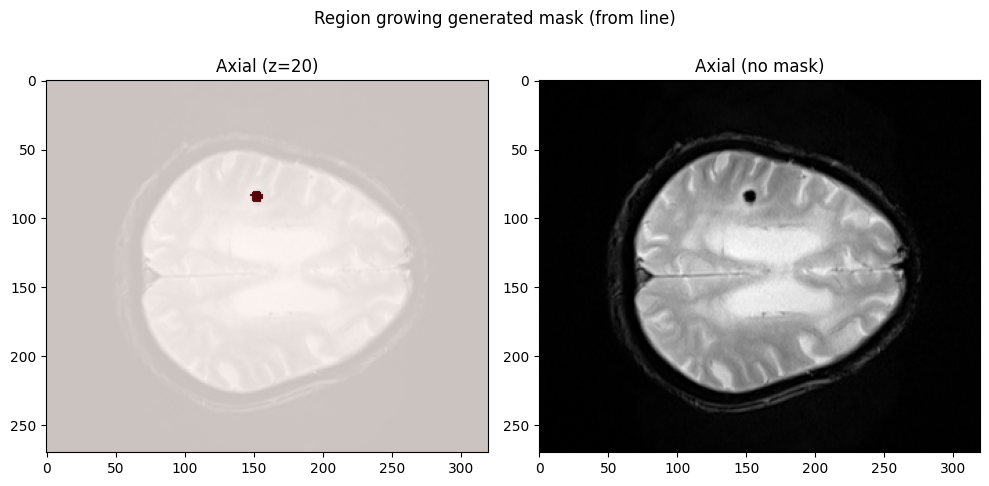

In [52]:
plot_mask_on_image(t2s_data, grown_mask, cmb_coord[0], axes_to_display=['axial'], alpha=0.8, title="Region growing generated mask (from line)")